In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
# Download and Tensorize images 
transform=transforms.Compose([transforms.ToTensor()])
train_data=torchvision.datasets.CIFAR10(download=True,root=r'C:\Users\wyy\Desktop\python',train=True,transform=transform)
test_data=torchvision.datasets.CIFAR10(download=True,root=r'C:\Users\wyy\Desktop\python',train=False,transform=transform)
# Normalize images data
def cal_mean_std(train_data):
    '''
    Compute the mean and std of 3 RGB values of train_data
    '''
    train_loader=torch.utils.data.DataLoader(train_data,batch_size=1,shuffle=False,num_workers=2)
    mean=torch.zeros(3)
    std=torch.zeros(3)
    for x,_ in train_loader:
        for i in range(3):
            mean[i]+=x[:,i,:,:].mean()
            std[i]+=x[:,i,:,:].std()
    mean.div_(len(train_data))
    std.div_(len(train_data))
    return list(mean.numpy()),list(std.numpy())
mean=cal_mean_std(train_data)[0]
std=cal_mean_std(train_data)[1]
# Normalize RGB values of images data
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=mean,std=std)])
train_data=torchvision.datasets.CIFAR10(download=True,root=r'C:\Users\wyy\Desktop\python',train=True,transform=transform)
test_data=torchvision.datasets.CIFAR10(download=True,root=r'C:\Users\wyy\Desktop\python',train=False,transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


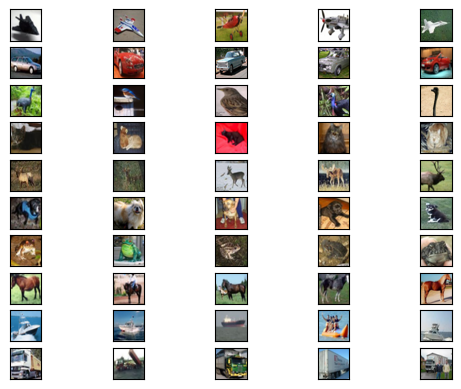

In [28]:
# Show 5 pictures of each class
import numpy as np
import matplotlib.pyplot as plt
n_classes=10
fig,ax=plt.subplots(n_classes,5)
labels=np.fromiter((t[1] for t in train_data),int)
for i in range(n_classes):
    index=np.where(labels==i)[0]
    for j in range(5):
        ax[i][j].imshow(train_data[index[j]][0].permute(1,2,0).numpy())
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
plt.show()       

In [3]:
# Construct Network
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        neuro1=32
        neuro2=32
        neuro3=64
        neuro4=64
        ks1=2
        ks2=2
        p1=0.25
        p2=0.25
        p3=0.5
        in1=4096
        out1=512
        self.c1=nn.Conv2d(3,neuro1,kernel_size=3,padding=1)
        self.c2=nn.Conv2d(neuro1,neuro2,kernel_size=3,padding=1)
        self.p1=nn.MaxPool2d(kernel_size=ks1)
        self.do1=nn.Dropout(p=p1)
        self.c3=nn.Conv2d(neuro2,neuro3,kernel_size=3,padding=1)
        self.c4=nn.Conv2d(neuro3,neuro4,kernel_size=3,padding=1)
        self.p2=nn.MaxPool2d(kernel_size=ks2)
        self.do2=nn.Dropout(p=p2)
        self.fc1=nn.Linear(in1,out1)
        self.do3=nn.Dropout(p=p3)
        self.fc2=nn.Linear(out1,n_classes)
    def forward(self,x):
        X=F.relu(self.c1(x))
        X=F.relu(self.c2(X))
        X=self.p1(X)
        X=self.do1(X)
        X=F.relu(self.c3(X))
        X=F.relu(self.c4(X))
        X=self.p2(X)
        X=self.do2(X)
        X=X.view(len(X),-1)
        X=F.relu(self.fc1(X))
        X=self.do3(X)
        X=self.fc2(X)
        return X

In [5]:
# Define hyper parameters,set seed and set optimiization method and loss function 
import numpy as np
from torch.utils.data import DataLoader
n_epochs=25
batch_size=64
learning_rate=1e-3

torch.manual_seed(123)
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False

trainloader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
testloader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

model=CNN(10)

optimizer=optim.Adam(model.parameters(),lr=learning_rate)
criterion=F.cross_entropy


In [7]:
# Train
from tqdm import tqdm
for epoch in range(n_epochs):
    loss=0
    accuracy=0
    n=0
    model.train()

    with tqdm(trainloader) as pbar:
        for images,labels in pbar:
            pred=model(images)
            loss=criterion(pred,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            n+=len(labels)
            loss+=loss.detach().numpy()*len(labels)
            accuracy+=(torch.argmax(pred,dim=1)\
            ==labels).sum().detach().numpy()

            pbar.set_postfix({'Epoch':epoch+1,'Loss':f'{loss/n:3f}','accuracy':f'{accuracy/n:3f}'})
        

100%|██████████| 782/782 [01:34<00:00,  8.25it/s, Epoch=25, Loss=0.000164, accuracy=0.878280]


In [9]:
# Test
loss=0
accuracy=0
n=0
model.eval()
with tqdm(testloader) as pbar:
    for images,labels in pbar:
        pred=model(images)
        loss=criterion(pred,labels)
        n+=len(labels)
        loss+=loss.detach().numpy()*len(labels)
        accuracy+=(torch.argmax(pred,dim=1)\
        ==labels).sum().detach().numpy()
        pbar.set_postfix({'Epoch':epoch+1,'Loss':f'{loss/n:3f}','accuracy':f'{accuracy/n:3f}'})

100%|██████████| 157/157 [00:07<00:00, 20.21it/s, Epoch=25, Loss=0.001578, accuracy=0.801400]
